### Section 0: Preparation
First, import the necessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import platform
import scipy
import statsmodels.api as sm
import sys

from matplotlib import pyplot as plt
from matplotlib import cm as colmap
from scipy import signal

# check python version is correct
p = sys.version_info
assert((p.major == 3) & (p.minor == 10) & (p.micro == 11))
del p

# cross-check package versions are correct
assert(mpl.__version__ == '3.7.1')  # matplotlib
assert(np.__version__ == '1.25.0')  # numpy
assert(pd.__version__ == '2.0.2')  # pandas
assert(scipy.__version__ == '1.11.0')  # scipy
assert(sm.__version__ == '0.13.5')  # statsmodels
mpl.rcParams.update({"axes.grid" : False})

This function, taken from https://towardsdatascience.com/optimize-memory-tips-in-python-3bbb44512937, reduces the amount of memory that a dataframe consumes. We use this to reduce computational load

In [2]:
def data_optimize(df, object_option=False):
    """Reduce the size of the input dataframe
    Parameters
    ----------
    df: pd.DataFrame
        input DataFrame
    object_option : bool, default=False
        if true, try to convert object to category
    Returns
    -------
    df: pd.DataFrame
        data type optimized output dataframe]

    Taken from https://towardsdatascience.com/optimize-memory-tips-in-python-3bbb44512937
    """

    # loop columns in the dataframe to downcast the dtype
    for col in df.columns:
        # process the int columns
        if df[col].dtype == 'int':
            col_min = df[col].min()
            col_max = df[col].max()
            # if all are non-negative, change to uint
            if col_min >= 0:
                if col_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif col_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif col_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                else:
                    df[col] = df[col]
            else:
                # if it has negative values, downcast based on the min and max
                if col_max < np.iinfo(np.int8).max and col_min > np.iinfo(np.int8).min:
                    df[col] = df[col].astype(np.int8)
                elif col_max < np.iinfo(np.int16).max and col_min > np.iinfo(np.int16).min:
                    df[col] = df[col].astype(np.int16)
                elif col_max < np.iinfo(np.int32).max and col_min > np.iinfo(np.int32).min:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col]

        # process the float columns
        elif df[col].dtype == 'float':
            col_min = df[col].min()
            col_max = df[col].max()
            # downcast based on the min and max
            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col]

        if object_option:
            if df[col].dtype == 'object':
                if len(df[col].value_counts()) < 0.5 * df.shape[0]:
                    df[col] = df[col].astype('category')

    return df

This function defines the default parameters for the model. Users can specify the inputs when calling the function if they wish to alter any of the parameters.

In [3]:
def get_params(fs=1000, T=5001, Ne=320, Ni=80, osc_ratio=0.2, ei_ratio=2/5, ee=0, ei=0.5, ie=-0.6, ii=-1.0,
               dc=4.2, npp=1, seed=0, freqs=0):

    # set random seed
    np.random.seed(seed)

    # define basic parameters
    params = dict()
    params['fs'] = fs
    params['T'] = T
    params['Ne'] = Ne
    params['Ni'] = Ni
    params['osc_ratio'] = osc_ratio
    params['ei_ratio'] = ei_ratio
    params['dc'] = dc
    params['npp'] = npp
    params['freqs'] = freqs

    # define neuron parameters
    params['a'] = np.concatenate([0.02 * np.ones(Ne), (0.02 * np.ones(Ni)) + (0.08 * np.random.rand(Ni))])
    params['b'] = np.concatenate([0.2 * np.ones(Ne), (0.25 * np.ones(Ni)) - (0.05 * np.random.rand(Ni))])
    params['c'] = np.concatenate([(-65 * np.ones(Ne)) + (15 * (np.random.rand(Ne) ** 2)), -65 * np.ones(Ni)])
    params['d'] = np.concatenate([(8 * np.ones(Ne)) - (6 * (np.random.rand(Ne) ** 2)), 2 * np.ones(Ni)])
    params['v'] = -65 * np.ones(Ne + Ni)
    params['u'] = params['b'] * params['v']

    # define connectivity
    c_mat_e = np.concatenate([ee * np.random.rand(Ne, Ne), ei * np.random.rand(Ni, Ne)], axis=0)
    c_mat_i = np.concatenate([ie * np.random.rand(Ne, Ni), ii * np.random.rand(Ni, Ni)], axis=0)
    params['S'] = np.concatenate([c_mat_e, c_mat_i], axis=1)
    np.fill_diagonal(params['S'], 0)

    return params


This function calculates the input that we will present to the network. There is a DC component, a sine wave, and normally distributed noise. All aspects of the input are determined by 'p', a dictionary containing the parameters defined in the last function. 'fi' provides the index for which frequency (contained in 'p') to use.

In [4]:
def calculate_input(p, fi):
    # for each cell, calculate the input the cell receives over time. This input varies as a function of direct
    # current (dc), the ratio of oscillatory input to "dc" (osc_ratio), and the percentage of "dc" passed to
    # inhibitory cells (ei_ratio). A time-series of inputs is returned for each cell (I).

    # compute oscillatory input (excit. only)
    amp = (p['dc'] * p['osc_ratio'])
    osc_input = ((amp * np.sin(2 * np.pi * p['freqs'][fi] * np.arange(0, p['T']) / p['fs'])) + amp) / 2
    osc_input = np.concatenate([np.repeat(osc_input[:, np.newaxis], p['Ne'], axis=1).transpose(),
                               np.zeros((p['Ni'], p['T']))])

    # compute direct input
    dir_input = np.concatenate([p['dc'] * np.ones((p['Ne'], p['T'])) + (p['dc']/10) *
                                np.random.randn(p['Ne'], p['T']), p['dc'] * p['ei_ratio'] *
                                np.ones((p['Ni'], p['T'])) + ((p['dc'] * p['ei_ratio'])/10) *
                                np.random.randn(p['Ni'], p['T'])])

    # return summed input
    ex_in = dir_input + osc_input

    # stagger onset to avoid artificial synchrony
    stagger_win = p['fs'] * 0.1  # stagger by 100ms
    for neuron in range(0, np.size(ex_in, axis=0)):
        neuron_delay = int(np.random.rand(1) * stagger_win)
        ex_in[neuron, :neuron_delay] = 0

    del osc_input
    return ex_in

This function runs the model, as outlined by Izhikevich (2004), given the pre-specified parameters ('p') and the network input ('ex_in').

In [5]:
def run_model(p, ex_in):
    # run the standard Izhikevich model, returning when spikes occurred (firings), the voltage over time (volts)
    # and the inputs at a given moment in time (inputs)

    # extract variables
    Ne = p['Ne']
    Ni = p['Ni']
    T = p['T']
    v = p['v']
    u = p['u']
    S = p['S']
    a = p['a']
    b = p['b']
    c = p['c']
    d = p['d']

    # predefine loop outputs
    fs_ = np.zeros((Ne + Ni, T))
    vs_ = np.zeros((T, 2))
    is_ = np.zeros((T, 2))

    # cycle through samples
    for t in np.arange(0, T):

        # address firing neurons
        fired = np.where(v >= 30)[0]  # find units that fire
        for n in fired:
            fs_[n, t] = 1
            v[n] = c[n]
            u[n] = u[n]+d[n]

        # add voltage results to dataframe
        vs_[t, :] = [np.mean(v[:Ne]), np.mean(v[Ne:])]

        # add exo. and endo. stimulation to numpy array
        is_[t, :] = [np.mean(ex_in[:, t], axis=0), np.mean(np.sum(S[:, fired], axis=1))]

        # define time point input
        I = ex_in[:, t] + np.sum(S[:, fired], axis=1)

        # update neuron values
        v = v+(0.04*v**2+5*v+140-u+I)
        u = u+a*(b*v-u)

    # return key values
    del Ne, Ni, a, b, c, d, u, v, S, T, t, fired
    return fs_, vs_, is_

This function organises the data returned from the model

In [6]:
def create_output_dataframes(p, sto_, voo_, spo_):
    # define the output dataframes for three variables of interest (volts, spikes, and input).

    # extract variables
    Ne = p['Ne']
    Ni = p['Ni']
    T = p['T']

    # predefine output dataframes
    N = Ne+Ni
    vs_ = pd.DataFrame(np.zeros((T * 2, 4)), columns=['t', 'f', 'cell', 'vals'])
    sp_ = pd.DataFrame(np.zeros((T * (Ne + Ni), 4)), columns=['t', 'f', 'neuron', 'spike'])
    st_ = pd.DataFrame(np.zeros((T * 2, 4)), columns=['t', 'f', 'type', 'vals'])

    # add in times/freqs/cells to voltage dataframe
    vs_['cell'] = np.repeat(['e', 'i'], T)
    vs_['t'] = np.tile(np.arange(0, T), 2)
    vs_['vals'] = np.concatenate(voo_)
    vs_ = data_optimize(vs_)

    # add in times/freqs/cells to spike-time dataframe
    if spo_ != None:
        sp_['neuron'] = np.repeat(np.arange(0, N), T)
        sp_['t'] = np.tile(np.arange(0, T), N)
        sp_['spike'] = np.concatenate(spo_)
        sp_ = data_optimize(sp_)
    else:
        sp_ = None

    # add in times/freqs to stimulation dataframe
    st_['type'] = np.repeat(['exo', 'endo'], T)
    st_['t'] = np.tile(np.arange(0, T), 2)
    st_['vals'] = np.concatenate(sto_)
    st_ = data_optimize(st_)

    # return
    del Ne, Ni, T, N
    return vs_, sp_, st_

This function uses Welch's method to estimate the power spectrum of the 'v' parameter returned from the model.

In [7]:
def get_fft(xi, trim_edges=True, nperseg=1000):
    if trim_edges:
        n = int(np.size(xi) / 10)
        xi = xi[n:-n]
        del n
    fwelch, spec = scipy.signal.welch(xi, fs=1000, window='hann', nperseg=nperseg, noverlap=nperseg-50)
    spec = spec[fwelch <= 150]
    fwelch = fwelch[fwelch <= 150]
    peak_f = fwelch[max(spec) == spec][0]
    return fwelch, spec, peak_f

This function determines the power of the most prominent spectral peak in the data.

In [8]:
def get_power_at_peak(x, fr):

    # get peak power for every participant and exogenous frequency
    powi = np.zeros(np.size(x, axis=0))
    for pi in range(0, np.size(x, axis=0)):
        tmp_pow = x[pi, fr]  # get power around endogenous peak
        tmp_peak = np.argmax(tmp_pow)
        powi[pi] = tmp_pow[tmp_peak]

    # return key values
    del pi, tmp_pow, tmp_peak
    return powi

This function calculates the peak-to-peak delay between oscillatory cycles, together with the amplitude of the oscillation

In [9]:
def get_peak_to_peak(xi):
    volt_z = scipy.stats.zscore(xi)
    peaks = scipy.signal.find_peaks(volt_z, prominence=1)
    hist_peaks, _ = np.histogram(np.diff(peaks[0]), np.arange(0, 152))
    hist_peaks = hist_peaks / (np.size(peaks[0])-1)
    yi = hist_peaks
    zi = peaks[1]['prominences'].mean()
    return yi, zi

This function normalises an input so that the minimum is 0 and the maximum is 1.

In [10]:
def normalise(xi):
    yi = (xi - min(xi)) / (max(xi) - min(xi))
    return yi

This function smooths an input using a moving average of size 'span'

In [11]:
def smooth(x, span):
    if span % 2 == 0:
        span += 1
    a = int(np.floor(span / 2))
    b = int(np.ceil(span / 2))
    y = np.zeros(np.size(x))
    for i in np.arange(0, np.size(x)):
        idx = np.arange(i-a, i+b)
        idx = idx[idx >= 0]
        idx = idx[idx < np.size(x)]
        y[i] = np.mean(x[idx])
    return y

### Section 1: The Basic Model
First, we define the necessary directories and set the RNG seed.

In [12]:
# define key directories
if platform.system() == 'Windows':
    data_directory = 'C:/Users/griffibz/Dropbox/work_data/beh_gammaFlicker/'
else:
    data_directory = '/Users/ben/Dropbox/work_data/beh_gammaFlicker/'

# reset seed
rand_seed = 1
np.random.seed(rand_seed)

We define how the model parameters vary as a function of model type. The first model is the 'slow gamma' model, which has a small DC input. The second is the 'fast gamma' model, which has a larger DC input to excite the cells more rapidly. The last is the 'arrhythmic' model, which has the same DC input as the 'slow' gamma model, but internal network connections are silenced to prevent the generation of gamma oscillations. Target frequencies ranging from 5Hz to 140Hz are also defined.

In [13]:
# define model-varying parameters
mod_var = {'dc_var': [4.26, 15.25, 4.26],
           'endo_var': [32, 64, 32],
           'ie_var': [-0.6, -0.6, 0],
           'ii_var': [-1, -1, 0]}
target_freqs = np.concatenate((np.zeros(1), np.arange(5, 141, 1.25)))

#### Section 1.1: An Example Model
Here, we are going to run one version of the 'fast gamma' model to demonstrate what each stage produces. First, we define the parameters based on what came above. Oscillatory input strength is exaggerated to help visualise the example.

In [14]:
# define target freqs.
params = get_params(seed=rand_seed, dc=mod_var['dc_var'][1],
                    ie=mod_var['ie_var'][1], ii=mod_var['ii_var'][1],
                    freqs=np.array(target_freqs), osc_ratio=0.5)

Next, we reset the random seed and determine the exogenous input into the network. In the main loop, only one exogenous input is generated. Here, two are produced to provide an intuition of the differences between the DC-only and DC+sine inputs.

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/604055345.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neuron_delay = int(np.random.rand(1) * stagger_win)


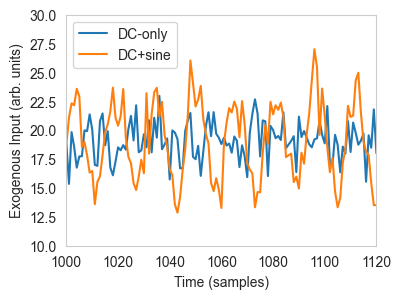

In [15]:
# reset seed so underlying endogenous dynamics are identical no matter the exogenous input
np.random.seed(rand_seed)

# define input for freq. condition
exo_input = calculate_input(params, 0)
exo_input_withStim = calculate_input(params, 49)  # 49 is the index for 65Hz stim.

# plot
plt.subplots(1, 1, figsize=(4, 3))
plt.plot(exo_input[0, :], label='DC-only')
plt.plot(exo_input_withStim[0, :], label='DC+sine')
plt.xlim([1000, 1120])
plt.xlabel('Time (samples)')
plt.ylim([10, 30])
plt.ylabel('Exogenous Input (arb. units)')
plt.legend()
plt.show()

Here's the key moment when we run the model, which returns information about spiking and LFP. As above, we will run two models here to compare the effect of stimulation, but this is a purely descriptive exercise at this stage.

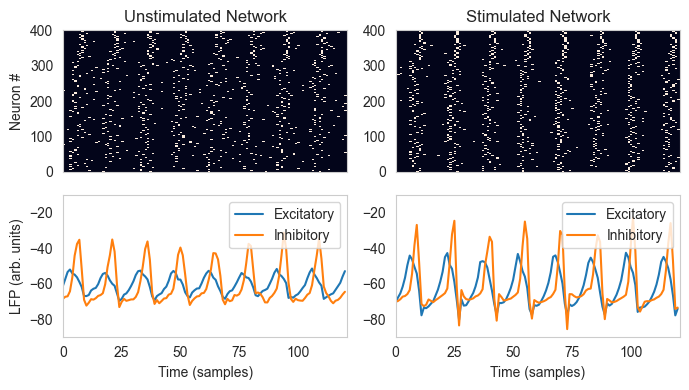

In [16]:
# run model
spikes_noStim, LFP_noStim, _ = run_model(params, exo_input)
spikes_wStim, LFP_wStim, _ = run_model(params, exo_input_withStim)

# plot
_, ax = plt.subplots(2, 2, figsize=(7, 4), sharex='all')
ax[0, 0].pcolor(spikes_noStim[:, 1000:1121])
ax[0, 0].set_ylabel('Neuron #')
ax[0, 0].set_title('Unstimulated Network')
ax[1, 0].plot(LFP_noStim[1000:1121, 0], label='Excitatory')
ax[1, 0].plot(LFP_noStim[1000:1121, 1], label='Inhibitory')
ax[1, 0].set_ylim([-90, -10])
ax[1, 0].set_xlabel('Time (samples)')
ax[1, 0].set_ylabel('LFP (arb. units)')
ax[1, 0].legend(loc='upper right')
ax[0, 1].pcolor(spikes_wStim[:, 1000:1121])
ax[0, 1].set_title('Stimulated Network')
ax[1, 1].plot(LFP_wStim[1000:1121, 0], label='Excitatory')
ax[1, 1].plot(LFP_wStim[1000:1121, 1], label='Inhibitory')
ax[1, 1].set_ylim([-90, -10])
ax[1, 1].set_xlabel('Time (samples)')
ax[1, 1].legend(loc='upper right')
plt.tight_layout()
plt.show()

# tidy up
del spikes_noStim, spikes_wStim, ax, exo_input, exo_input_withStim, _

We can then get the power spectrum of the LFP to look for peaks in the data

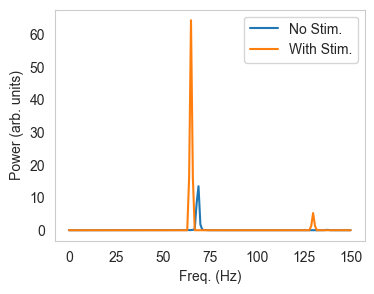

In [17]:
# compute FFT
freqs, power_noStim, _ = get_fft(LFP_noStim[:, 0])
_, power_wStim, _ = get_fft(LFP_wStim[:, 0])

# plot
plt.subplots(1, 1, figsize=(4, 3))
plt.plot(freqs, power_noStim, label='No Stim.')
plt.plot(freqs, power_wStim, label='With Stim.')
plt.xlabel('Freq. (Hz)')
plt.ylabel('Power (arb. units)')
plt.legend()
plt.show()

# tidy up
del freqs, power_noStim, power_wStim, _

We can also explore non-Fourier based estimates of oscillatory duration and amplitude

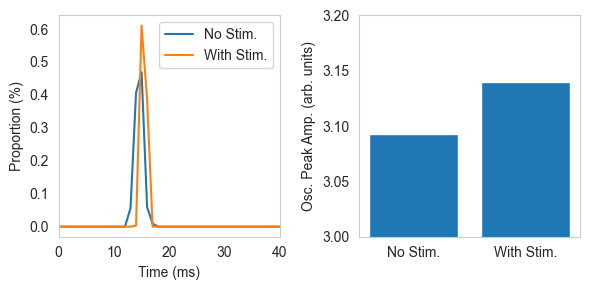

In [18]:
# get delays and amplitudes
delay_noStim, amp_noStim = get_peak_to_peak(LFP_noStim[:, 0])
delay_wStim, amp_wStim = get_peak_to_peak(LFP_wStim[:, 0])

# create figure
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# plot histogram of peak-to-peak delays
ax[0].plot(delay_noStim, label='No Stim.')
ax[0].plot(delay_wStim, label='With Stim.')
ax[0].set_xlim([0, 40])
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Proportion (%)')
ax[0].legend()

# plot oscillatory amplitude
ax[1].bar(x=[1, 2], height=[amp_noStim, amp_wStim])
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(['No Stim.', 'With Stim.'])
ax[1].set_ylabel('Osc. Peak Amp. (arb. units)')
ax[1].set_ylim([3, 3.2])
ax[1].set_yticks(np.arange(3, 3.21, 0.05))
plt.tight_layout()

# tidy up
del delay_wStim, delay_noStim, amp_wStim, amp_noStim, LFP_wStim, LFP_noStim, ax, fig, params

#### Section 1.2: The Big Loop
First, we define necessary output variables

In [19]:
# create empty numpy arrays for exemplar outputs
stim = [[], [], []]
volts = stim.copy()
spikes = stim.copy()

# create dataframe for key outputs (five columns = )
group_ts = np.zeros((np.size(mod_var['dc_var']), np.size(target_freqs), 5001))
group_stim = np.zeros((np.size(mod_var['dc_var']), np.size(target_freqs), 5001))
group_power = np.zeros((np.size(mod_var['dc_var']), np.size(target_freqs), 151))  # [model, exo_freq, endo_freq]
group_peak = np.zeros((np.size(mod_var['dc_var']), np.size(target_freqs)))  # [model, exo_freq]
group_nonFourier_peak = np.zeros((np.size(mod_var['dc_var']), np.size(target_freqs), 151))  # [model, exo_freq, time]
group_nonFourier_amp = np.zeros((np.size(mod_var['dc_var']), np.size(target_freqs)))  # [model, exo_freq]

Now, we run many iterations of the three models, using a range of stimulation frequencies.

In [20]:
# reset seed so underlying endogenous dynamics are identical no matter the exogenous input
np.random.seed(rand_seed)


# cycle through each model
for m in np.arange(0, np.size(mod_var['dc_var'])):

    # define target freqs.
    params = get_params(seed=rand_seed, dc=mod_var['dc_var'][m],
                        ie=mod_var['ie_var'][m], ii=mod_var['ii_var'][m],
                        freqs=np.array(target_freqs), osc_ratio=0.1)

    # create empty numpy arrays for outputs (faster than iteratively adding to dataframe)
    stim_output = []
    volts_output = []
    spikes_output = []

    # cycle through each exogenous frequency
    for f in np.arange(0, np.size(params['freqs'])):

        # reset seed so underlying endogenous dynamics are identical no matter the exogenous input
        np.random.seed(rand_seed)

        # define input for freq. condition
        exo_input = calculate_input(params, f)

        # run model
        firings, volt_ts, inputs = run_model(params, exo_input)
        group_ts[m, f, :] = volt_ts[:, 0]
        group_stim[m, f, :] = inputs[:, 0]
        del exo_input

        # compute FFT
        _, group_power[m, f, :], group_peak[m, f] = get_fft(volt_ts[:, 0])
        del _

        # compute non-Fourier measures
        group_nonFourier_peak[m, f, :], group_nonFourier_amp[m, f] = get_peak_to_peak(volt_ts[:, 0])

        # add inputs to dataframe
        if (f == 0):
            stim_output.append(inputs[:, 0])  # add exogenous input
            stim_output.append(inputs[:, 1])  # add endogenous input
            volts_output.append(volt_ts[:, 0])  # add excitatory v
            volts_output.append(volt_ts[:, 1])  # add inhibitory v
            spikes_output.append(np.concatenate(firings))

        # tidy workspace
        print("model {}, freq {} complete...".format(m, f))
        del firings, inputs, volt_ts, f

    # convert outputs into dataframe
    volts[m], spikes[m], stim[m] = create_output_dataframes(params, stim_output, volts_output, spikes_output)
    del stim_output, volts_output, spikes_output, m

# update user
print("all models complete...")

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/604055345.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neuron_delay = int(np.random.rand(1) * stagger_win)


model 0, freq 0 complete...
model 0, freq 1 complete...
model 0, freq 2 complete...
model 0, freq 3 complete...
model 0, freq 4 complete...
model 0, freq 5 complete...
model 0, freq 6 complete...
model 0, freq 7 complete...
model 0, freq 8 complete...
model 0, freq 9 complete...
model 0, freq 10 complete...
model 0, freq 11 complete...
model 0, freq 12 complete...
model 0, freq 13 complete...
model 0, freq 14 complete...
model 0, freq 15 complete...
model 0, freq 16 complete...
model 0, freq 17 complete...
model 0, freq 18 complete...
model 0, freq 19 complete...
model 0, freq 20 complete...
model 0, freq 21 complete...
model 0, freq 22 complete...
model 0, freq 23 complete...
model 0, freq 24 complete...
model 0, freq 25 complete...
model 0, freq 26 complete...
model 0, freq 27 complete...
model 0, freq 28 complete...
model 0, freq 29 complete...
model 0, freq 30 complete...
model 0, freq 31 complete...
model 0, freq 32 complete...
model 0, freq 33 complete...
model 0, freq 34 complet

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/604055345.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neuron_delay = int(np.random.rand(1) * stagger_win)


model 1, freq 0 complete...
model 1, freq 1 complete...
model 1, freq 2 complete...
model 1, freq 3 complete...
model 1, freq 4 complete...
model 1, freq 5 complete...
model 1, freq 6 complete...
model 1, freq 7 complete...
model 1, freq 8 complete...
model 1, freq 9 complete...
model 1, freq 10 complete...
model 1, freq 11 complete...
model 1, freq 12 complete...
model 1, freq 13 complete...
model 1, freq 14 complete...
model 1, freq 15 complete...
model 1, freq 16 complete...
model 1, freq 17 complete...
model 1, freq 18 complete...
model 1, freq 19 complete...
model 1, freq 20 complete...
model 1, freq 21 complete...
model 1, freq 22 complete...
model 1, freq 23 complete...
model 1, freq 24 complete...
model 1, freq 25 complete...
model 1, freq 26 complete...
model 1, freq 27 complete...
model 1, freq 28 complete...
model 1, freq 29 complete...
model 1, freq 30 complete...
model 1, freq 31 complete...
model 1, freq 32 complete...
model 1, freq 33 complete...
model 1, freq 34 complet

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/604055345.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neuron_delay = int(np.random.rand(1) * stagger_win)


model 2, freq 0 complete...
model 2, freq 1 complete...
model 2, freq 2 complete...
model 2, freq 3 complete...
model 2, freq 4 complete...
model 2, freq 5 complete...
model 2, freq 6 complete...
model 2, freq 7 complete...
model 2, freq 8 complete...
model 2, freq 9 complete...
model 2, freq 10 complete...
model 2, freq 11 complete...
model 2, freq 12 complete...
model 2, freq 13 complete...
model 2, freq 14 complete...
model 2, freq 15 complete...
model 2, freq 16 complete...
model 2, freq 17 complete...
model 2, freq 18 complete...
model 2, freq 19 complete...
model 2, freq 20 complete...
model 2, freq 21 complete...
model 2, freq 22 complete...
model 2, freq 23 complete...
model 2, freq 24 complete...
model 2, freq 25 complete...
model 2, freq 26 complete...
model 2, freq 27 complete...
model 2, freq 28 complete...
model 2, freq 29 complete...
model 2, freq 30 complete...
model 2, freq 31 complete...
model 2, freq 32 complete...
model 2, freq 33 complete...
model 2, freq 34 complet

#### Section 1.3: Fitting the Behaviour to the Model
In this section, we see how well the models fit to the behavioural data. First, we load in the behavioural data

In [21]:
# load model data
beh_models = pd.read_csv('{}/data_groupModels.csv'.format(data_directory))
beh_models = beh_models.query('dataset == 0 and outcome == "recalled"')

# extract behavioural data
beh_data = np.zeros((np.size(np.unique(beh_models['pp'])), 3))
beh_data[:, 0] = beh_models['regressor_t'][beh_models['predictor'] == '33Hz_retrieval'].to_list()
beh_data[:, 1] = beh_models['regressor_t'][beh_models['predictor'] == '43Hz_retrieval'].to_list()
beh_data[:, 2] = beh_models['regressor_t'][beh_models['predictor'] == '65Hz_retrieval'].to_list()

# extract outliers
outliers = np.zeros((np.size(np.unique(beh_models['pp'])), 3))
outliers[:, 0] = beh_models['outlier'][beh_models['predictor'] == '33Hz_retrieval'].to_list()
outliers[:, 1] = beh_models['outlier'][beh_models['predictor'] == '43Hz_retrieval'].to_list()
outliers[:, 2] = beh_models['outlier'][beh_models['predictor'] == '65Hz_retrieval'].to_list()

# restrict data to good participants
good_pps = (outliers==0).all(axis=1)
beh_data = beh_data[good_pps, :]
npp = np.size(beh_data, axis=0)

# scale behavioural data
beh_data = scipy.stats.zscore(beh_data, axis=1)

# tidy up
del beh_models, good_pps, outliers

Then, we extract the power of the peak frequency of the model following stimulation and compare this to the power of the peak frequency of the model when stimulation did not occur. This is repeated for each stimulation frequency and each model.

In [22]:
# define stimulation frequencies used in behavioural task and find closest values in model
beh_freqs = [130/4, 130/3, 130/2]
exo_idx = [np.argmin(abs(n - target_freqs)) for n in beh_freqs]
endo_freqs = np.linspace(0, 150, np.size(group_power, axis=2))

# calculate how peak power changes following stimulation for each model
model_t = np.zeros((3, 3))
for m in range(3):
    peak_freq = endo_freqs[np.argmax(group_power[m, 0, :])]
    freq_range = (endo_freqs>peak_freq-5) & (endo_freqs<peak_freq+5)
    base_pow = np.mean(group_power[m, 0, freq_range])
    for f in range(3):
        stim_pow = np.mean(group_power[m, exo_idx[f], freq_range])
        model_t[m, f] = stim_pow - base_pow
        del stim_pow, f
    del peak_freq, freq_range, base_pow, m
del endo_freqs, beh_freqs

Lastly, replicate the model data to provide data for every participant, add a constant, and then fit the data.

In [23]:
# fit model
X = np.tile(scipy.stats.zscore(model_t).transpose(), npp).transpose()
y = beh_data.flatten()
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
del X, y, model, results, model_t

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.161
Model:                            OLS   Adj. R-squared (uncentered):              0.144
Method:                 Least Squares   F-statistic:                              9.560
Date:                Thu, 20 Jul 2023   Prob (F-statistic):                    0.000159
Time:                        15:11:06   Log-Likelihood:                         -135.81
No. Observations:                 102   AIC:                                      275.6
Df Residuals:                     100   BIC:                                      280.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

This process can then be repeated for the non-Fourier data

In [24]:
# calculate how peak power changes following stimulation for each model
model_t = np.zeros((3, 3))
for m in range(3):
    base_pow = group_nonFourier_amp[m, 0]
    for f in range(3):
        stim_pow = group_nonFourier_amp[m, exo_idx[f]]
        model_t[m, f] = stim_pow - base_pow
        del stim_pow, f
    del base_pow, m

# fit model
X = np.tile(scipy.stats.zscore(model_t).transpose(), npp).transpose()
y = beh_data.flatten()
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
del X, y, model, results, model_t, exo_idx, npp

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.161
Model:                            OLS   Adj. R-squared (uncentered):              0.144
Method:                 Least Squares   F-statistic:                              9.560
Date:                Thu, 20 Jul 2023   Prob (F-statistic):                    0.000159
Time:                        15:11:06   Log-Likelihood:                         -135.81
No. Observations:                 102   AIC:                                      275.6
Df Residuals:                     100   BIC:                                      280.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Section 1.4: Plotting the Results
First, we define some plot parameters

In [25]:
# %% Define Plot Parameters
# set pyplot defaults
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.major.pad'] = 2
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['xtick.major.pad'] = 2

# set local defaults
img_style = {'title': dict(fontsize=7, fontweight='bold'), 'axlabel': dict(fontsize=7),
             'ticklabel': dict(fontsize=5, color='black')}
cm = 1/2.54

# define model names
model_names = ["Slow Gamma", "Fast Gamma", "Arrhythmic"]

# define colours
pastels = np.array([[129, 192, 227], [171, 213, 236], [226, 163, 129]]) / 255

Then, we plot a snapshot of network dynamics, including a time-series of the v parameter and a raster plot of the same window. This will become figure 2B.

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/1484396121.py:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[idx].scatter(e_events.t, e_events.neuron, s=0.1, c=pastels[m])
/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/1484396121.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[idx].scatter(i_events.t, i_events.neuron, s=0.1, c=[0.8, 0.8, 0.8])


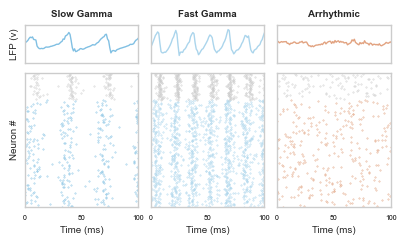

In [26]:
# create custom grid
fig = plt.figure(figsize=(12*cm, 6*cm))
gs = mpl.gridspec.GridSpec(4, 6, wspace=0.25, hspace=0.25)  # 2x2 grid

# create axes for subplot A (raw spikes/LFP)
ax = [[]] * 6
ax[0] = fig.add_subplot(gs[0, 0:2]) # first row, first col
ax[1] = fig.add_subplot(gs[1:4, 0:2]) # first row, first col
ax[2] = fig.add_subplot(gs[0, 2:4]) # first row, first col
ax[3] = fig.add_subplot(gs[1:4, 2:4]) # first row, first col
ax[4] = fig.add_subplot(gs[0, 4:6]) # first row, first col
ax[5] = fig.add_subplot(gs[1:4, 4:6]) # first row, first col

# ------- plot subplot A
# prepare spike plot
sts = 1900
sts_end = 100  # duration of displayed epoch (100ms in samples)
volt_ts = np.zeros((3, max(volts[0]['t'])+1))
for m in [0, 1, 2]:
    v1 = volts[m].query("f==0 and cell=='e'")['vals'].to_numpy()
    v2 = volts[m].query("f==0 and cell=='i'")['vals'].to_numpy()
    volt_ts[m, :] = (v1 + v2) / 2
    del m
sylims = [min(np.concatenate(volt_ts[:, sts:sts+100])) * 1.1, max(np.concatenate(volt_ts[:, sts:sts+100])) / 1.1]
del v1, v2

# plot spikes for each freq. condition
for m in [0, 1, 2]:

    # plot input
    idx = m*2
    times = volts[m].query("f==0 and cell=='e'")['t'].to_numpy()
    ax[idx].plot(times, volt_ts[m, :], c=pastels[m], linewidth=1)
    ax[idx].set_xlim([sts, sts+sts_end])
    ax[idx].set_ylim([min(volt_ts[m, sts:sts+sts_end]) * 1.1, max(volt_ts[m, sts:sts+sts_end]) / 1.1])
    ax[idx].set_yticks([])
    ax[idx].set_title(model_names[m], **img_style['title'])
    if m == 0:
        ax[idx].set_ylabel('LFP (v)', **img_style['axlabel'])
    else:
        plt.setp(ax[idx].get_yticklabels(), visible=False)

    # plot spikes
    idx = 1 + m*2
    e_events = spikes[m].query("spike>0 and neuron<{} and f==0".format(params['Ne']))
    i_events = spikes[m].query("spike>0 and neuron>={} and f==0".format(params['Ne']))
    ax[idx].scatter(e_events.t, e_events.neuron, s=0.1, c=pastels[m])
    ax[idx].scatter(i_events.t, i_events.neuron, s=0.1, c=[0.8, 0.8, 0.8])
    ax[idx].set_xlim([sts, sts+sts_end])
    ax[idx].set_xticks([sts, sts+(sts_end/2), sts+sts_end])
    ax[idx].set_xticklabels(['0', '50', '100'], **img_style['ticklabel'])
    ax[idx].set_xlabel('Time (ms)', **img_style['axlabel'])
    ax[idx].set_ylim([0, params['Ne']+params['Ni']])
    ax[idx].set_yticks([])
    plt.setp(ax[idx-1].get_xticklabels(), visible=False)
    if m == 0:
        ax[idx].set_ylabel('Neuron #', **img_style['axlabel'])
    else:
        plt.setp(ax[idx].get_yticklabels(), visible=False)
        plt.setp(ax[idx].get_ylabel(), visible=False)

    # tidy workspace
    del idx, e_events, i_events, times, m

# show plot
plt.savefig("{}/figures/figure2b.eps".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0,
            transparent=True, facecolor=[1, 1, 1])

# tidy up
del fig, gs, ax, sylims

Then, plot the power spectra for each of the three models prior to stimulation. This will be figure 2C.

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/571921747.py:10: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gs_curve = scipy.signal.gaussian(7, 1) / sum(scipy.signal.gaussian(7, 1))


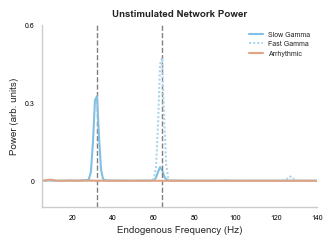

In [27]:
# create plot
fig, ax = plt.subplots(1, 1, figsize=(9*cm, 6*cm))

# define freqs
endo_freqs = np.linspace(0, 150, np.size(group_power, axis=2))
exo_freqs = target_freqs[1:]
linestyle = ['-', (0, (1, 1)), '-']

# get mean power
gs_curve = scipy.signal.gaussian(7, 1) / sum(scipy.signal.gaussian(7, 1))
avg_power = group_power[:, 0, :]
peak_freq = [0, 0]
for m in [0, 1, 2]:
    signal = np.convolve(avg_power[m, :], gs_curve, mode='same')
    signal = signal / mod_var['dc_var'][m]  # scale according to input drive
    if m != 2:
        peak_freq[m] = endo_freqs[np.argmax(signal)]
        ax.axvline(peak_freq[m], linestyle='--', c=[0.5, 0.5, 0.5], linewidth=1)
    ax.plot(endo_freqs, signal, c=pastels[m], linestyle=linestyle[m], linewidth=1.5, label=model_names[m])

# add detail
ax.set_xlabel('Endogenous Frequency (Hz)', **img_style['axlabel'])
ax.set_ylabel('Power (arb. units)', **img_style['axlabel'])
ax.set_xlim([5, 140])
ax.set_xticks(np.arange(10, 141, 10))
ax.set_xticklabels(['', '20', '', '40', '', '60', '', '80', '', '100', '', '120', '', '140'], **img_style['ticklabel'])
ax.set_ylim([-0.1, 0.6])
ax.set_yticks(np.arange(-0.1, 0.7, 0.1))
ax.set_yticklabels(['', '0', '', '', '0.3', '', '', '0.6'], **img_style['ticklabel'])
ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc='upper right', fontsize=5, frameon=False)
ax.set_title('Unstimulated Network Power', **img_style['title'])

# show plot
plt.savefig("{}/figures/figure2c.eps".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0,
            transparent=True, facecolor=[1, 1, 1])

# tidy
del endo_freqs, exo_freqs, linestyle, gs_curve, avg_power, peak_freq, m, signal, ax

Plot frequency-frequency plots to depict how exogenous stimulation impacts endogenous rhythms for each of the three models. This will form figure 2E.

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/2000491567.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = colmap.get_cmap('inferno', 5)
/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/2000491567.py:24: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = scipy.interpolate.interp2d(endo_freqs, exo_freqs

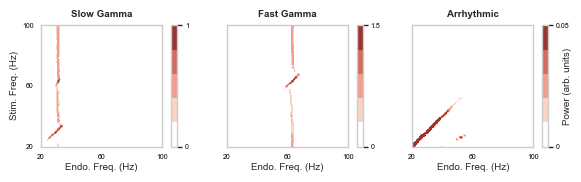

In [28]:
fig = plt.figure(figsize=(18*cm, 4*cm))
gs = mpl.gridspec.GridSpec(5, 15, wspace=0.25, hspace=0.25)  # 2x2 grid

# create colour map
colours_for_map = np.array([[255, 255, 255, 255], [248, 212, 196, 255], [241, 158, 143, 255], [211, 107, 95, 255], [153, 54, 49, 255]]) / 255
cmap = colmap.get_cmap('inferno', 5)
cmap.colors = colours_for_map

ax_c = [[]] * 3
ax_c[0] = fig.add_subplot(gs[:, :5], aspect='equal')
ax_c[1] = fig.add_subplot(gs[:, 5:10], aspect='equal')
ax_c[2] = fig.add_subplot(gs[:, 10:15], aspect='equal')

# plot pcolor
endo_freqs = np.linspace(0, 150, np.size(group_power, axis=2))
exo_freqs = target_freqs[1:]
clim = [1, 1.5, 0.05]
for m in range(3):

    X, Y = np.meshgrid(endo_freqs, exo_freqs)
    Z = group_power[m, 1:, :] / mod_var['dc_var'][m]
    x2 = np.linspace(endo_freqs[0], endo_freqs[-1], np.size(endo_freqs)*2)
    y2 = np.linspace(exo_freqs[0], exo_freqs[-1], np.size(exo_freqs)*2)
    f = scipy.interpolate.interp2d(endo_freqs, exo_freqs, Z, kind='cubic')
    Z2 = f(x2, y2)
    Z3 = scipy.ndimage.filters.gaussian_filter(Z2, 0.5, mode='constant')
    h = ax_c[m].pcolor(x2, y2, Z3, vmin=0, vmax=clim[m], cmap=cmap)
    cbar = plt.colorbar(h, ax=ax_c[m], ticks=[0, clim[m]])
    cbar.ax.set_yticklabels([0, clim[m]], **img_style['ticklabel'])
    if m == 2:
        cbar.ax.set_ylabel('Power (arb. units)', labelpad=-5, **img_style['axlabel'])
    ax_c[m].set(xlim=[20, 100], ylim=[20, 100], xticks=np.arange(20, 101, 20))
    ax_c[m].set_xticklabels(['20', '', '60', '', '100'], **img_style['ticklabel'])
    ax_c[m].set_xlabel('Endo. Freq. (Hz)', labelpad=2, **img_style['axlabel'])
    ax_c[m].set_title(model_names[m], **img_style['title'])
    if m == 0:
        ax_c[m].set_yticks(np.arange(20, 101, 20))
        ax_c[m].set_yticklabels(['20', '', '60', '', '100'], **img_style['ticklabel'])
        ax_c[m].set_ylabel('Stim. Freq. (Hz)', labelpad=2, **img_style['axlabel'])
    else:
        ax_c[m].set_yticks([])
    del X, Y, Z, x2, y2, f, Z2, Z3, h, cbar, m

# show
plt.savefig("{}/figures/figure2d.tif".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0,
            transparent=True, facecolor=[1, 1, 1])

# tidy
del endo_freqs, exo_freqs, clim, ax_c, colours_for_map, cmap, fig, gs

Plot how 32.5Hz, 43.3Hz and 65Hz stimulation impacts endogenous oscillatory power (relative to baseline) and compare this to the behavioural data. This will become figure 2F.

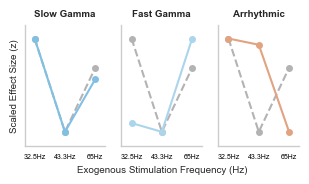

In [29]:
# create figure
fig, ax = plt.subplots(1, 3, figsize=(9*cm, 4*cm))

# define behavioural t-values
beh_freqs = [130/4, 130/3, 130/2]
beh_t = [5.08, -0.84, 3.22]

# define stimulation frequencies used in behavioural task and find closest values in model
endo_freqs = np.linspace(0, 150, np.size(group_power, axis=2))
exo_idx = [np.argmin(abs(n - target_freqs)) for n in beh_freqs]
model_freqs = [beh_freqs[0], beh_freqs[2], beh_freqs[0]]

# calculate how peak power changes following stimulation for each model
model_t = np.zeros((3, 3))
for m in range(3):
    peak_freq = endo_freqs[np.argmax(group_power[m, 0, :])]
    freq_range = (endo_freqs>peak_freq-5) & (endo_freqs<peak_freq+5)
    base_pow = np.mean(group_power[m, 0, freq_range])
    for f in range(3):
        stim_pow = np.mean(group_power[m, exo_idx[f], freq_range])
        model_t[m, f] = stim_pow - base_pow
        del stim_pow, f
    del peak_freq, freq_range, base_pow, m
del endo_freqs, exo_idx

# scale model t-values to match behavioural
scaled_t = np.zeros(np.shape(model_t))
for m in range(3):
    beh_std = np.std(beh_t)
    model_t[m, :] = (model_t[m, :] / np.std(model_t[m, :])) * beh_std
    del beh_std

# plot
stim_names = ["32.5Hz", "43.3Hz", "65Hz"]
for m in range(3):
    x = np.array([0, 0.3, 0.6])
    y = (np.array(beh_t) - min(beh_t)) / (max(beh_t) - min(beh_t))
    ax[m].plot(x, y, 'o--', c=[0.7, 0.7, 0.7], linewidth=1.5, markersize=4)
    y = (model_t[m, :] - min(model_t[m, :])) / (max(model_t[m, :]) - min(model_t[m, :]))
    ax[m].plot(x, y, 'o-', c=pastels[m], linewidth=1.5, markersize=4)

    # add detail
    ax[m].set_xlim([-0.1, 0.7])
    ax[m].set_xticks(x)
    ax[m].set_xticklabels(stim_names, **img_style['ticklabel'])
    if m == 1:
        ax[m].set_xlabel('Exogenous Stimulation Frequency (Hz)', **img_style['axlabel'])
    ax[m].set_ylim([-0.15, 1.15])
    ax[m].set_yticks([])
    if m == 0:
        ax[m].set_ylabel('Scaled Effect Size (z)', **img_style['axlabel'])
    ax[m].spines[['right', 'top']].set_visible(False)
    ax[m].set_title(model_names[m], **img_style['title'])
    del m, y, x

# show
plt.savefig("{}/figures/figure2e.eps".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0,
            transparent=True, facecolor=[1, 1, 1])

# tidy up
del stim_names, ax, fig, scaled_t, model_t, beh_freqs, beh_t

Plot visualisation of peak detection

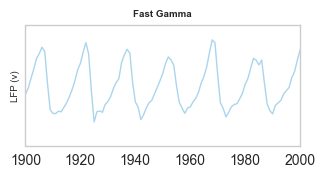

In [30]:
fig, ax = plt.subplots(1, 1,  figsize=(9*cm, 4*cm))
times = volts[1].query("f==0 and cell=='e'")['t'].to_numpy()
ax.plot(times, volt_ts[1, :], c=pastels[1], linewidth=1)
ax.set_xlim([sts, sts+sts_end])
ax.set_ylim([min(volt_ts[1, sts:sts+sts_end]) * 1.1, max(volt_ts[1, sts:sts+sts_end]) / 1.1])
ax.set_yticks([])
ax.set_title(model_names[1], **img_style['title'])
ax.set_ylabel('LFP (v)', **img_style['axlabel'])

# save plot
plt.savefig("{}/figures/figure2f.eps".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0,
            transparent=True, facecolor=[1, 1, 1])

# tidy workspace
del fig, ax, times, sts, sts_end, volt_ts,

Plot the delays between oscillatory peaks (figure 2G)

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/3286595429.py:9: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gs_curve = scipy.signal.gaussian(7, 1) / sum(scipy.signal.gaussian(7, 1))


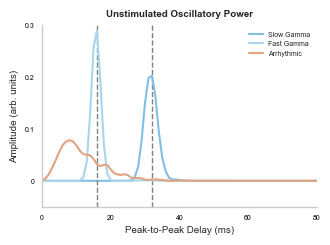

In [31]:
# create plot
fig, ax = plt.subplots(1, 1, figsize=(9*cm, 6*cm))

# define freqs
endo_times = np.linspace(0, 150, np.size(group_nonFourier_peak, axis=2))
exo_freqs = target_freqs[1:]

# get mean power
gs_curve = scipy.signal.gaussian(7, 1) / sum(scipy.signal.gaussian(7, 1))
avg_power = group_nonFourier_peak[:, 0, :]
peak_freq = [0, 0]
for m in [0, 1, 2]:
    signal = np.convolve(avg_power[m, :], gs_curve, mode='same')
    if m != 2:
        peak_freq[m] = endo_times[np.argmax(signal)]
        ax.axvline(peak_freq[m], linestyle='--', c=[0.5, 0.5, 0.5], linewidth=1)
    ax.plot(endo_times, signal, c=pastels[m], linestyle='-', linewidth=1.5, label=model_names[m])

# add detail
ax.set_xlabel('Peak-to-Peak Delay (ms)', **img_style['axlabel'])
ax.set_ylabel('Amplitude (arb. units)', **img_style['axlabel'])
ax.set_xlim([0, 80])
ax.set_xticks(np.arange(0, 81, 10))
ax.set_xticklabels(['0', '', '20', '', '40', '', '60', '', '80'], **img_style['ticklabel'])
ax.set_ylim([-0.05, 0.3])
ax.set_yticks(np.arange(-0.05, 0.31, 0.05))
ax.set_yticklabels(['', '0', '', '0.1', '', '0.2', '', '0.3'], **img_style['ticklabel'])
ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc='upper right', fontsize=5, frameon=False)
ax.set_title('Unstimulated Oscillatory Power', **img_style['title'])

# show plot
plt.savefig("{}/figures/figure2g.eps".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0,
            transparent=True, facecolor=[1, 1, 1])

# tidy
del endo_times, exo_freqs, gs_curve, avg_power, peak_freq, m, signal, ax

Plot how 32.5Hz, 43.3Hz and 65Hz stimulation impacts oscillatory amplitude (relative to baseline) and compare this to the behavioural data. This will become figure 2H.

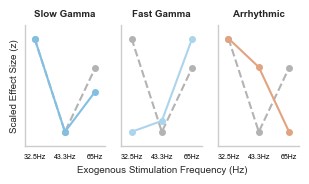

In [32]:
# create figure
fig, ax = plt.subplots(1, 3, figsize=(9*cm, 4*cm))

# define behavioural t-values
beh_freqs = [130/4, 130/3, 130/2]
beh_t = [5.08, -0.84, 3.22]

# define stimulation frequencies used in behavioural task and find closest values in model
endo_freqs = np.linspace(0, 150, np.size(group_power, axis=2))
exo_idx = [np.argmin(abs(n - target_freqs)) for n in beh_freqs]
model_freqs = [beh_freqs[0], beh_freqs[2], beh_freqs[0]]

# calculate how peak power changes following stimulation for each model
model_t = np.zeros((3, 3))
for m in range(3):
    base_pow = group_nonFourier_amp[m, 0]
    for f in range(3):
        stim_pow = group_nonFourier_amp[m, exo_idx[f]]
        model_t[m, f] = stim_pow - base_pow
        del stim_pow, f
    del base_pow, m
del exo_idx

# fit model
# scale model t-values to match behavioural
scaled_t = np.zeros(np.shape(model_t))
for m in range(3):
    beh_std = np.std(beh_t)
    model_t[m, :] = (model_t[m, :] / np.std(model_t[m, :])) * beh_std
    del beh_std, m

# plot
stim_names = ["32.5Hz", "43.3Hz", "65Hz"]
for m in range(3):
    x = np.array([0, 0.3, 0.6])
    y = (np.array(beh_t) - min(beh_t)) / (max(beh_t) - min(beh_t))
    ax[m].plot(x, y, 'o--', c=[0.7, 0.7, 0.7], linewidth=1.5, markersize=4)
    y = (model_t[m, :] - min(model_t[m, :])) / (max(model_t[m, :]) - min(model_t[m, :]))
    ax[m].plot(x, y, 'o-', c=pastels[m], linewidth=1.5, markersize=4)

    # add detail
    ax[m].set_xlim([-0.1, 0.7])
    ax[m].set_xticks(x)
    ax[m].set_xticklabels(stim_names, **img_style['ticklabel'])
    if m == 1:
        ax[m].set_xlabel('Exogenous Stimulation Frequency (Hz)', **img_style['axlabel'])
    ax[m].set_ylim([-0.15, 1.15])
    ax[m].set_yticks([])
    if m == 0:
        ax[m].set_ylabel('Scaled Effect Size (z)', **img_style['axlabel'])
    ax[m].spines[['right', 'top']].set_visible(False)
    ax[m].set_title(model_names[m], **img_style['title'])
    del m, x, y

# show
plt.savefig("{}/figures/figure2h.eps".format(data_directory), dpi=500, bbox_inches='tight', pad_inches=0,
            transparent=True, facecolor=[1, 1, 1])

# tidy up
del stim_names, beh_freqs, beh_t, ax, fig, endo_freqs, scaled_t, model_t

In [33]:
# general tidy up
del group_power, group_peak, group_stim, group_ts, group_nonFourier_peak, group_nonFourier_amp, img_style, beh_data, \
    pastels, params, cm, mod_var, model_freqs, model_names, spikes, stim, target_freqs, volts

#### Section 2.1: Harmonic Arnold Tongues
Here, we re-run the slow gamma model and expose it to the three experimental stimulation frequencies. Critically, we systematically vary the DC input to subtly modulate the endogenous peak frequency, which allows us to explore how the influence of stimulation changes as a function of distance to the endogenous peak frequency.

In [34]:
# define stimulation frequencies
target_freqs = [0, 32.5, 43.3, 65]

# define differing direct currents
dc_input = np.arange(3.4, 5.4, 0.02)

# create dataframe for key outputs (five columns = )
group_power = np.zeros((np.size(dc_input), np.size(target_freqs), 301))  # [model, exo_freq, endo_freq, val]
group_peak = np.zeros((np.size(dc_input), np.size(target_freqs)))  # [model, exo_freq, val]

# cycle through each model
for m in np.arange(0, np.size(dc_input)):

    # define target freqs.
    params = get_params(seed=rand_seed, dc=dc_input[m], freqs=np.array(target_freqs))

    # cycle through each exogenous frequency
    for f in np.arange(0, np.size(params['freqs'])):

        # reset seed so underlying endogenous dynamics are identical no matter the exogenous input
        np.random.seed(rand_seed)

        # define input for freq. condition
        exo_input = calculate_input(params, f)

        # run model
        _, volt_ts, _ = run_model(params, exo_input)

        # compute FFT
        _, group_power[m, f, :], group_peak[m, f] = get_fft(volt_ts[:, 0], nperseg=2000)

        # tidy workspace
        del exo_input, volt_ts, f, _

    # update user
    print("model {} complete...".format(m))
    del m

# drop duplicates
u, c = np.unique(group_peak[:, 0], return_counts=True)
while any(c > 1):
    dup_val = u[c > 1][0]
    dup_idx = np.where(group_peak[:, 0] == dup_val)[0][1:]
    group_peak = np.delete(group_peak, dup_idx, axis=0)
    group_power = np.delete(group_power, dup_idx, axis=0)
    u, c = np.unique(group_peak[:, 0], return_counts=True)
    del dup_idx, dup_val

# update user
print("all models complete...")

# tidy up
del u, c, dc_input, target_freqs, params

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/604055345.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neuron_delay = int(np.random.rand(1) * stagger_win)


model 0 complete...
model 1 complete...
model 2 complete...
model 3 complete...
model 4 complete...
model 5 complete...
model 6 complete...
model 7 complete...
model 8 complete...
model 9 complete...
model 10 complete...
model 11 complete...
model 12 complete...
model 13 complete...
model 14 complete...
model 15 complete...
model 16 complete...
model 17 complete...
model 18 complete...
model 19 complete...
model 20 complete...
model 21 complete...
model 22 complete...
model 23 complete...
model 24 complete...
model 25 complete...
model 26 complete...
model 27 complete...
model 28 complete...
model 29 complete...
model 30 complete...
model 31 complete...
model 32 complete...
model 33 complete...
model 34 complete...
model 35 complete...
model 36 complete...
model 37 complete...
model 38 complete...
model 39 complete...
model 40 complete...
model 41 complete...
model 42 complete...
model 43 complete...
model 44 complete...
model 45 complete...
model 46 complete...
model 47 complete...
mo

We can then plot Arnold Tongues for each stimulation frequency (figure 3A)

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/3351006133.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = colmap.get_cmap('Reds', 100)


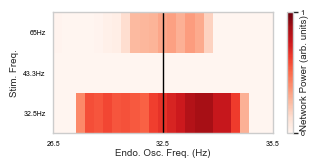

In [35]:
# define plot parameters
stim_names = ["32.5Hz", "43.3Hz", "65Hz"]
img_style = {'title': dict(fontsize=7, fontweight='bold'), 'axlabel': dict(fontsize=7), 'ticklabel': dict(fontsize=5, color='black')}
cm = 1/2.54
pastels = np.array([[129, 192, 227], [171, 213, 236], [226, 163, 129]]) / 255

# create figure
fig, ax = plt.subplots(figsize=(9*cm, 4*cm))

# create colour map
colours_for_map = np.array([[255, 255, 255, 255], [248, 212, 196, 255], [241, 158, 143, 255], [211, 107, 95, 255], [153, 54, 49, 255]]) / 255
colours_expanded = np.zeros((np.size(colours_for_map, axis=0)*20, np.size(colours_for_map, axis=1)))
for n in range(np.size(colours_for_map, axis=1)):
    f = scipy.interpolate.interp1d(np.linspace(0, 1, np.size(colours_for_map, axis=0)), colours_for_map[:, n])
    colours_expanded[:, n] = f(np.linspace(0, 1, np.size(colours_expanded, axis=0)))
    del f, n
colours_expanded[0, :] = [1, 1, 1, 1]
cmap = colmap.get_cmap('Reds', 100)
cmap.colors = colours_expanded
del colours_expanded, colours_for_map

# plot A
endo_freqs = np.linspace(0, 150, np.size(group_power, axis=2))

# calculate how peak power changes following stimulation for each model
n_models = np.size(group_power, axis=0)
model_t = np.zeros((n_models, 3))
for m in range(n_models):
    peak_freq = endo_freqs[np.argmax(group_power[m, 0, :])]
    freq_range = (endo_freqs>peak_freq-5) & (endo_freqs<peak_freq+5)
    base_pow = np.mean(group_power[m, 0, freq_range])
    for f in range(3):
        stim_pow = np.mean(group_power[m, f+1, freq_range])
        model_t[m, f] = stim_pow - base_pow
        del stim_pow, f
    del base_pow, freq_range, peak_freq, m

# restrict analysis so the plot centres on 32.5Hz
model_t = model_t[(group_peak[:, 0] >= 26.5) & (group_peak[:, 0] <= 38.5), :]
freqs = group_peak[(group_peak[:, 0] >= 26.5) & (group_peak[:, 0] <= 38.5), 0]

# plot pcolor
h = ax.pcolor(freqs, [1, 2, 3], model_t.transpose(), vmin=0, vmax=1, cmap=cmap)
ax.axvline(32.5, c='k', linewidth=1)
ax.set_xlim([26.5, 38.5])
ax.set_xticks([26.5, 32.5, 38.5])
ax.set_xticklabels([26.5, 32.5, 38.5], **img_style['ticklabel'])
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(stim_names, **img_style['ticklabel'])
ax.set_ylabel('Stim. Freq.', labelpad=3, **img_style['axlabel'])
cbar = plt.colorbar(h, ax=ax)
cbar.ax.set_yticks([0, 1])
cbar.ax.set_yticklabels([0, 1], **img_style['ticklabel'])
ax.set_xlabel('Endo. Osc. Freq. (Hz)', labelpad=1, **img_style['axlabel'])
cbar.ax.set_ylabel('Network Power (arb. units)', labelpad=-3, **img_style['axlabel'])

# plot
plt.savefig("{}/figures/figure3a.eps".format(data_directory), dpi=500, bbox_inches='tight',
            pad_inches=0, transparent=True, facecolor=[1, 1, 1])

# tidy workspace
del ax, fig, cbar, freqs, n_models, endo_freqs, h, stim_names

And between-frequency correlations (figure 3b)

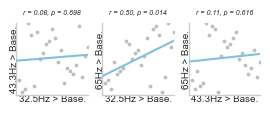

In [36]:
# create figure
_, ax = plt.subplots(1, 3, figsize=(8*cm, 4*cm))

# plot C
corr_pair = [[0, 1], [0, 2], [1, 2]]
label_pair = [['32.5Hz', '43.3Hz'], ['32.5Hz', '65Hz'], ['43.3Hz', '65Hz']]
for m in range(3):

    # get df
    x = scipy.stats.rankdata(model_t[:, corr_pair[m][0]]) #scipy.stats.rankdata()
    y = scipy.stats.rankdata(model_t[:, corr_pair[m][1]]) #scipy.stats.rankdata(model_t[:, corr_pair[m][1]])

    # get correlation
    r, p = scipy.stats.pearsonr(x, y)

    # get line of best fit
    X = np.vstack((np.ones(np.size(y)), x)).transpose()
    res = sm.OLS(y, X).fit()
    lob = np.array([0, np.size(model_t, axis=0)]) * res.params[1] + res.params[0]

    # plot correlation
    for n in range(np.size(x)):
        ax[m].scatter(x[n], y[n], s=3, facecolor=np.zeros(3)+0.75)
        del n

    # plot line of best fit
    ax[m].plot([0, np.size(model_t, axis=0)], lob, color=pastels[0], zorder=100, linewidth=1.5)

    # plot remainder
    ax[m].set_aspect('equal', 'box')
    ax[m].set_xlim([0, np.size(model_t, axis=0)])
    ax[m].set_ylim([0, np.size(model_t, axis=0)])
    ax[m].spines.right.set_visible(False)
    ax[m].spines.top.set_visible(False)
    ax[m].set_xticks([])
    ax[m].set_yticks([])
    ax[m].set_ylabel('{} > Base.'.format(label_pair[m][1]), labelpad=-2, **img_style['axlabel'])
    ax[m].set_xlabel('{} > Base.'.format(label_pair[m][0]), labelpad=0, **img_style['axlabel'])
    ax[m].set_title('r = {:2.2f}, p = {:3.3f}'.format(r, p), **dict(fontsize=img_style['ticklabel']['fontsize'],
                                                                    fontstyle='italic'))

    # tidy
    del x, y, r, p, X, res, lob, m

# show
plt.savefig("{}/figures/figure3c.eps".format(data_directory), dpi=500, bbox_inches='tight',
            pad_inches=0, transparent=True, facecolor=[1, 1, 1])

# tidy up
del ax, corr_pair, label_pair, group_peak, group_power, model_t, cm, img_style, cmap, pastels

### Section 3: Examining Further Harmonic Effects

This section explores what happens when stimulation occurs at different harmonic frequencies. The code is very similar to that used above, but the 'target frequencies' (i.e., the exogenous stimulation frequencies) are defined relative to the approximate endogenous peak frequency.

In [37]:
# create dataframe for key outputs
target_freqs = np.array([0, 1/8, 1/4, 1/2, 1, 2, 4, 8])
group_power = np.zeros((2, np.size(target_freqs), 151))  # [model, exo_freq, endo_freq, val]

# define dc inputs
dc_input = [4.26, 15.25]
osc_freq = [32.5, 65]

# cycle through models
for m in range(2):

    # define parameters
    params = get_params(seed=rand_seed, dc=dc_input[m], freqs=target_freqs * osc_freq[m])

    # cycle through each exogenous frequency
    for f in np.arange(0, np.size(params['freqs'])):

        # reset seed so underlying endogenous dynamics are identical no matter the exogenous input
        np.random.seed(rand_seed)

        # define input for freq. condition
        exo_input = calculate_input(params, f)

        # run model
        firings, volt_ts, inputs = run_model(params, exo_input)

        # compute FFT
        _, group_power[m, f, :], _ = get_fft(volt_ts[:, 0])

        # tidy workspace
        del exo_input, firings, inputs, volt_ts, f, _
    del m, params

# tidy up
del dc_input, osc_freq

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/604055345.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neuron_delay = int(np.random.rand(1) * stagger_win)


We can then plot the output as figure 4A

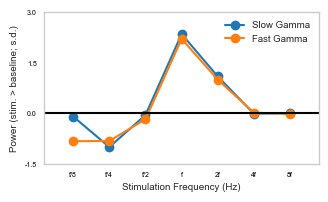

In [38]:
# define plot parameters
img_style = {'title': dict(fontsize=7, fontweight='bold'), 'axlabel': dict(fontsize=7),
             'ticklabel': dict(fontsize=5, color='black')}
cm = 1/2.54

# compute change in oscillatory power for conditions, then scale
endo_freqs = np.linspace(0, 150, np.size(group_power, axis=2))
osc_freq = [32.5, 65]
d = np.zeros((2, 7))
for m in range(2):
    idx = (endo_freqs>osc_freq[m]-5) & (endo_freqs<osc_freq[m]+5.1)
    a = group_power[m, 1:, idx].mean(axis=0)
    b = group_power[m, 0, idx].mean()
    d[m, :] = a - b
    d[m, :] = d[m, :] / d[m, :].std()
    del idx, a, b, m

# plot results
leg_label = ['Slow Gamma', 'Fast Gamma']
fig, ax = plt.subplots(1, 1, figsize=(9*cm, 5*cm))
for m in range(2):
    ax.plot(np.arange(np.size(target_freqs)-1), d[m, :], marker='o', label=leg_label[m])
    del m
ax.set_xlim([-0.8, 6.8])
ax.set_xticks(np.arange(0, 7))
ax.set_xticklabels(['f/8', 'f/4', 'f/2', 'f', '2f', '4f', '8f'], **img_style['ticklabel'])
ax.set_xlabel('Stimulation Frequency (Hz)', **img_style['axlabel'])
ax.set_ylim([-1.5, 3])
ax.set_yticks(np.arange(-1.5, 3.1, 1.5))
ax.set_yticklabels(np.round(np.arange(-1.5, 3.1, 1.5), 1), **img_style['ticklabel'])
ax.set_ylabel('Power (stim. > baseline; s.d.)', **img_style['axlabel'])
ax.axhline(0, color='k')
plt.legend(fontsize='x-small', frameon=False)

plt.savefig("{}/figures/figure4a.eps".format(data_directory), dpi=500, bbox_inches='tight',
            pad_inches=0, transparent=True, facecolor=[1, 1, 1])

# tidy up
del fig, ax, leg_label, d, osc_freq, endo_freqs, group_power, target_freqs, cm, img_style

We can also observe what is happening in the LFP time-series. Here, we use fewer harmonic frequencies as it is easier to subsequently plot and visualise

In [39]:
# define stimulation frequencies
target_freqs = 130 / np.array([16, 8, 4, 2, 1])

# define target freqs.
params = get_params(seed=rand_seed, freqs=np.array(target_freqs))

# predefine length of data
cycle_dur = np.round(params['fs'] / max(target_freqs))  # get length of one cycle of slowest freq. in samples
cycles_per_segment = int(max(params['freqs']) / min(target_freqs))  # get number of cycles nested in largest stim. freq
epoch_dur = int(cycle_dur * cycles_per_segment)  # define length of segment
del cycle_dur, cycles_per_segment

# predefine loop output
v_data = np.zeros((epoch_dur, np.size(target_freqs)))
o_data = np.zeros((epoch_dur, np.size(target_freqs)))

# cycle through each exogenous frequency
for f in np.arange(0, np.size(params['freqs'])):

    # reset seed so underlying endogenous dynamics are identical no matter the exogenous input
    np.random.seed(rand_seed)

    # --- run input function in line --- #
    # compute oscillatory input (excit. only)
    amp = (params['dc'] * params['osc_ratio'])
    osc_input = ((amp * np.sin(2 * np.pi * params['freqs'][f] * np.arange(0, params['T']) / params['fs'])) + amp) / 2
    osc_input = np.concatenate([np.repeat(osc_input[:, np.newaxis], params['Ne'], axis=1).transpose(),
                                np.zeros((params['Ni'], params['T']))])

    # compute direct input
    dir_input = np.concatenate( [params['dc'] * np.ones((params['Ne'], params['T'])) + (params['dc'] / 10) *
                                 np.random.randn(params['Ne'], params['T']), params['dc'] * params['ei_ratio'] *
                                 np.ones((params['Ni'], params['T'])) + ((params['dc'] * params['ei_ratio']) / 10) *
                                 np.random.randn(params['Ni'], params['T'])])

    # return summed input
    ex_in = dir_input + osc_input

    # stagger onset to avoid artificial synchrony
    stagger_win = params['fs'] * 0.1  # stagger by 100ms
    for neuron in range(0, np.size(ex_in, axis=0)):
        neuron_delay = int(np.random.rand(1) * stagger_win)
        ex_in[neuron, :neuron_delay] = 0

    # return output
    exo_input = ex_in
    del ex_in, neuron_delay, neuron, stagger_win, dir_input, amp

    # ----------------- #

    # run model
    _, volt_ts, _ = run_model(params, exo_input)
    del exo_input

    # restrict data to 1000ms after onset to avoid onset artifact
    v = volt_ts[1000:, 0]  # extract excitatory signal
    o = osc_input[0, 1000:]
    del volt_ts, osc_input

    # find peaks in oscillatory input and 'v'
    o_peaks = scipy.signal.find_peaks(smooth(-o, 5))[0]  # use troughs so initial ramp-up can be observed
    v_peaks = scipy.signal.find_peaks(smooth(v, 5))[0]  # use troughs so initial ramp-up can be observed

    # start epoching at 'o' peak that precedes first 'v'
    v_peaks = v_peaks[v_peaks > o_peaks[0]]  # ensure all v_peaks are greater than the first o_peak
    o_start = np.argmax(o_peaks[o_peaks < v_peaks[1]])
    o_peaks = o_peaks[o_start:]
    del v_peaks, o_start

    # define which 'o' peaks to extract data from
    cps = int(target_freqs[f] / min(params['freqs']))  # get number of cycles nested in largest stim. freq
    o_peaks = o_peaks[np.arange(0, np.size(o_peaks), cps)]  # drop intermediate samples to avoid overlap
    o_peaks = o_peaks[(o_peaks + epoch_dur) < np.size(v)]
    del cps

    # extract oscillatory input, LFP, and firing data
    v_data[:, f] = np.sum([v[n:(n+epoch_dur)] for n in o_peaks], axis=0) / np.size(o_peaks)
    o_data[:, f] = np.sum([o[n:(n+epoch_dur)] for n in o_peaks], axis=0) / np.size(o_peaks)

    # tidy workspace
    del v, o, o_peaks, f, _

# tidy workspace
del epoch_dur, params

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/1139609994.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neuron_delay = int(np.random.rand(1) * stagger_win)


And we can plot the output (as seen in Figure 4B)

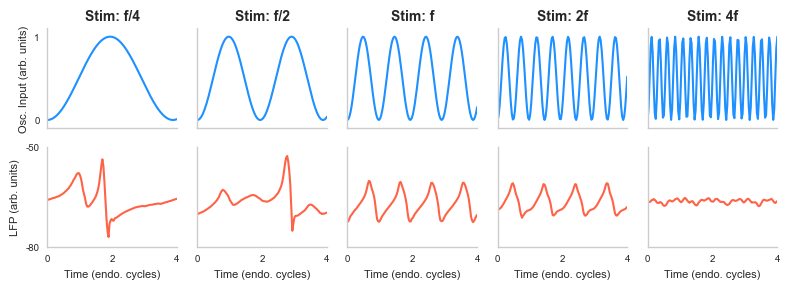

In [40]:
# define plot parameters
stim_names = ["32.5Hz", "43.3Hz", "65Hz"]
img_style = {'title': dict(fontsize=7, fontweight='bold'), 'axlabel': dict(fontsize=7),
             'ticklabel': dict(fontsize=5, color='black')}
cm = 1/2.54

# %% Plot
titles = ['f/4', 'f/2', 'f', '2f', '4f']
time = np.linspace(0, max(target_freqs)/32.5, np.size(o_data, axis=0))
fig, ax = plt.subplots(2, 5, sharey='row', sharex='all', figsize=(8, 3))
for n in range(5):
    ax[0, n].plot(time, normalise(o_data[:, n]), color='dodgerblue')
    if n == 0:
        ax[0, n].set_ylabel('Osc. Input (arb. units)', fontsize=8)
    ax[0, n].set_ylim([-0.1, 1.1])
    ax[0, n].set_yticks([0, 1])
    ax[0, n].set_yticklabels([0, 1], fontsize=7)
    ax[0, n].set_title('Stim: ' + titles[n], fontweight='bold', fontsize=10)
    ax[0, n].spines[['right', 'top']].set_visible(False)

    ax[1, n].plot(time, v_data[:, n], color='tomato')
    ax[1, n].set_ylim([-80, -50])
    ax[1, n].set_yticks([-80, -70, -60, -50])
    ax[1, n].set_yticklabels([-80, '', '', -50], fontsize=7)
    ax[1, n].set_xlim([0, 4])
    ax[1, n].set_xticks([0, 1, 2, 3, 4])
    ax[1, n].set_xticklabels([0, '', 2, '', 4], fontsize=7)
    ax[1, n].set_xlabel('Time (endo. cycles)', fontsize=8)
    ax[1, n].spines[['right', 'top']].set_visible(False)
    if n == 0:
        ax[1, n].set_ylabel('LFP (arb. units)', fontsize=8)
    del n

plt.tight_layout()
plt.savefig("{}/figures/figure4b.eps".format(data_directory), dpi=500, bbox_inches='tight',
            pad_inches=0, transparent=True, facecolor=[1, 1, 1])

# tidy up
del fig, ax, time, titles, cm, img_style, stim_names, o_data, v_data, target_freqs

### Section 4: Probing the Impact of Oscillatory Amplitude

Lastly, we can explore what happens when the amplitude of the exogenous input varies. The variable 'osc_input' carries this information and takes the values from 0.05 (i.e., 5% of the direct current input) to 0.8 (i.e., 80% of the direct current input). Note that as this model essentially runs the first section 6 times, it takes substantially longer to compute than other sections.

In [41]:
# %% Run Model w/ Oscillatory Amplitude Changes
# define stimulation frequencies
target_freqs = np.arange(0, 100)

# define differing direct currents
osc_input = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]

# create dataframe for key outputs (five columns = )
group_power = np.zeros((np.size(osc_input), np.size(target_freqs), 151))  # [model, exo_freq, endo_freq, val]

# cycle through each model
for m in np.arange(0, np.size(osc_input)):

    # define target freqs.
    params = get_params(seed=rand_seed, osc_ratio=osc_input[m], freqs=np.array(target_freqs))

    # cycle through each exogenous frequency
    for f in np.arange(0, np.size(params['freqs'])):

        # reset seed so underlying endogenous dynamics are identical no matter the exogenous input
        np.random.seed(rand_seed)

        # define input for freq. condition
        exo_input = calculate_input(params, f)

        # run model
        _, volt_ts, _ = run_model(params, exo_input)
        del exo_input

        # compute FFT
        _, group_power[m, f, :], _ = get_fft(volt_ts[:, 0])
        del volt_ts, f

    # update user
    print("model {} complete...".format(m))
    del params, m

# update user
print("all models complete...")

/var/folders/n4/4yfr_qsj01l2w4k6v2ksq22m0000gn/T/ipykernel_17543/604055345.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neuron_delay = int(np.random.rand(1) * stagger_win)


model 0 complete...
model 1 complete...
model 2 complete...
model 3 complete...
model 4 complete...
model 5 complete...
all models complete...


And we can plot the results as Supplementary Figure 2

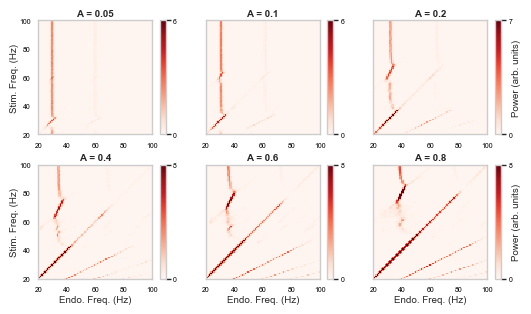

In [42]:
# define plot parameters
img_style = {'title': dict(fontsize=7, fontweight='bold'), 'axlabel': dict(fontsize=7),
             'ticklabel': dict(fontsize=5, color='black')}
cm = 1/2.54

# define model names
model_names = ["Slow Gamma Model", "Fast Gamma Model", "Arrhythmic Model"]
endo_freqs = np.linspace(0, 150, np.size(group_power, axis=2))
exo_freqs = target_freqs
stim_idx = [np.argmin(abs(exo_freqs - x)) for x in [130/4, 130/3, 130/2]]

# create figure
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14*cm, 8*cm))
ax = ax.flatten()

# plot FFs
ylims = [6, 6, 7, 8, 8, 8]
for n in range(np.size(group_power, axis=0)):
    ax[n].set_aspect('equal')
    h = ax[n].pcolor(endo_freqs, exo_freqs, group_power[n, :, :], vmin=0, vmax=ylims[n], cmap='Reds')
    ax[n].set_xlim([20, 100])
    ax[n].set_xticks(np.arange(20, 101, 20))
    ax[n].set_xticklabels(np.arange(20, 101, 20), **img_style['ticklabel'])
    ax[n].set_ylim([20, 100])
    ax[n].set_yticks(np.arange(20, 101, 20))
    ax[n].set_title('A = {}'.format(np.round(osc_input[n],2)), pad=3, **img_style['title'])
    if (n == 0) | (n == 3):
        ax[n].set_yticklabels(np.arange(20, 101, 20), **img_style['ticklabel'])
        ax[n].set_ylabel('Stim. Freq. (Hz)', labelpad=0, **img_style['axlabel'])
    else:
        ax[n].set_yticklabels([])
    if n >= 3:
        ax[n].set_xlabel('Endo. Freq. (Hz)', labelpad=2, **img_style['axlabel'])
    cbar = plt.colorbar(h, ax=ax[n])
    cbar.ax.set_yticks([0, ylims[n]])
    cbar.ax.set_yticklabels([0, ylims[n]], **img_style['ticklabel'])
    if (n == 2) | (n == 5):
        cbar.ax.set_ylabel('Power (arb. units)', labelpad=0, **img_style['axlabel'])
    del cbar, n, h

plt.tight_layout()
plt.savefig("{}/figures/supp_figure2.jpg".format(data_directory), dpi=500, bbox_inches='tight',
            pad_inches=0, transparent=True, facecolor=[1, 1, 1])

# tidy up
del fig, ax, ylims, stim_idx, exo_freqs, endo_freqs, model_names, cm, img_style, group_power, osc_input, target_freqs

And we're done...